<a href="https://colab.research.google.com/github/Dimildizio/DArc_course/blob/main/EDA/PimaKaggle/Pima_indians_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pima indians diabetes kaggle dataset

### import libs

In [2]:
%%capture
!pip install shap imbalanced-learn

In [124]:
import numpy as np
import pandas as pd
import seaborn as sns
import shap


from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import NearMiss
from matplotlib import pyplot as plt
from scipy.stats import boxcox
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.linear_model import LinearRegression, RidgeCV, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler

In [4]:
%matplotlib inline

### download dataset

In [5]:
%%capture
!wget -O pima.csv https://raw.githubusercontent.com/Dimildizio/DArc_course/main/EDA/PimaKaggle/pima-indians-diabetes.csv

In [6]:
columns = ['pregnancies','glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'BMI', 'pedigree', 'age', 'result']
data = pd.read_csv('pima.csv', names = columns)
data.head()

pregnancies  glucose  blood_pressure  skin_thickness  insulin   BMI  \
0            6      148              72              35        0  33.6   
1            1       85              66              29        0  26.6   
2            8      183              64               0        0  23.3   
3            1       89              66              23       94  28.1   
4            0      137              40              35      168  43.1   

   pedigree  age  result  
0     0.627   50       1  
1     0.351   31       0  
2     0.672   32       1  
3     0.167   21       0  
4     2.288   33       1

### Check the size of the dataset

In [7]:
data.shape

(768, 9)

### Check for NaNs and data types

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pregnancies     768 non-null    int64  
 1   glucose         768 non-null    int64  
 2   blood_pressure  768 non-null    int64  
 3   skin_thickness  768 non-null    int64  
 4   insulin         768 non-null    int64  
 5   BMI             768 non-null    float64
 6   pedigree        768 non-null    float64
 7   age             768 non-null    int64  
 8   result          768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### Convert float\int 64 to 32 for faster operatinos

In [9]:
def convert_dtype(data):
  for col in data.columns:
    if data[col].dtype == 'float64':
      data[col] = data[col].astype('float32')

    elif data[col].dtype == 'int64':
      data[col] = data[col].astype('int32')
  return data

In [10]:
data = convert_dtype(data)

### Get statistics by columns

In [11]:
pd.set_option('display.precision', 3)
data.describe()

pregnancies  glucose  blood_pressure  skin_thickness  insulin      BMI  \
count      768.000  768.000         768.000         768.000  768.000  768.000   
mean         3.845  120.895          69.105          20.536   79.799   31.993   
std          3.370   31.973          19.356          15.952  115.244    7.884   
min          0.000    0.000           0.000           0.000    0.000    0.000   
25%          1.000   99.000          62.000           0.000    0.000   27.300   
50%          3.000  117.000          72.000          23.000   30.500   32.000   
75%          6.000  140.250          80.000          32.000  127.250   36.600   
max         17.000  199.000         122.000          99.000  846.000   67.100   

       pedigree      age   result  
count   768.000  768.000  768.000  
mean      0.472   33.241    0.349  
std       0.331   11.760    0.477  
min       0.078   21.000    0.000  
25%       0.244   24.000    0.000  
50%       0.373   29.000    0.000  
75%       0.626   41.000    1.000  
max       2.420   81.000    1.000

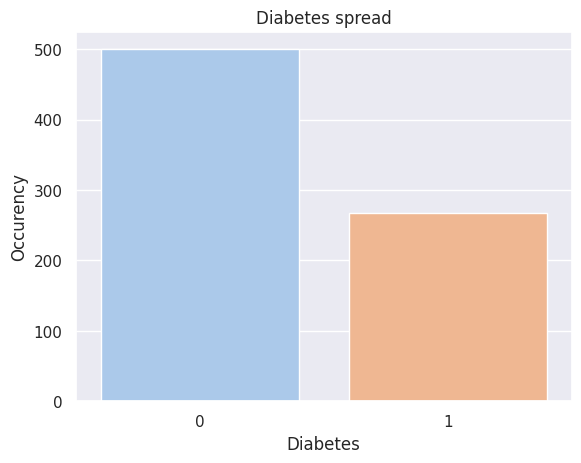

In [12]:
sns.set(style="darkgrid")
sns.set_palette('pastel')
sns.countplot(data=data, x='result')

plt.title('Diabetes spread')
plt.xlabel('Diabetes')
plt.ylabel('Occurency')
plt.show()

Not ideal distibution, so we'll have to address this issue later, possibly by adding sythetic rows.

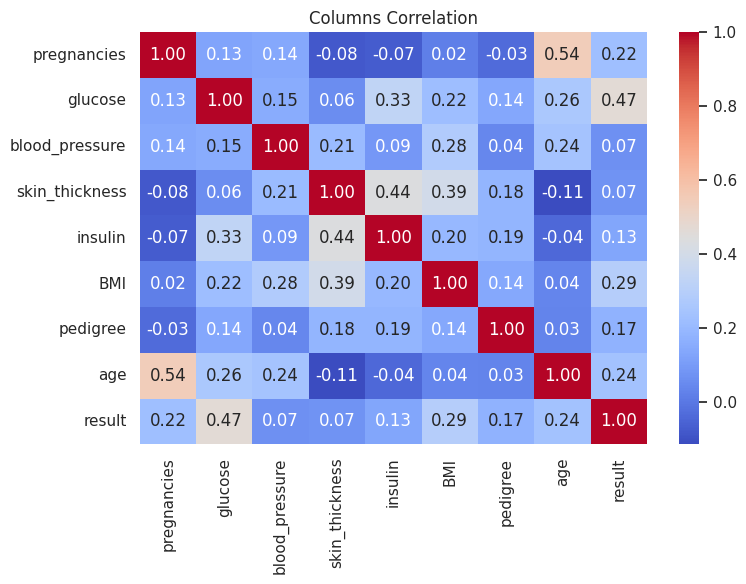

In [13]:
plt.figure(figsize=(8,6))

corr_matrix = data.corr()
sns.heatmap(data=corr_matrix, annot=True, fmt = '.2f', cmap='coolwarm')
plt.title('Columns Correlation')
plt.tight_layout()

Clearly a very "combed" dataset. No NaNs, no high correlation

### Check for skewness

In [14]:
def check_skew(data):
  skewness = data.skew()
  sns.barplot(x=skewness.index, y=skewness)
  plt.xticks(rotation=90)
  plt.xlabel('Columns')
  plt.ylabel('Skewness')
  plt.title('Skewness of Columns')
  plt.show()

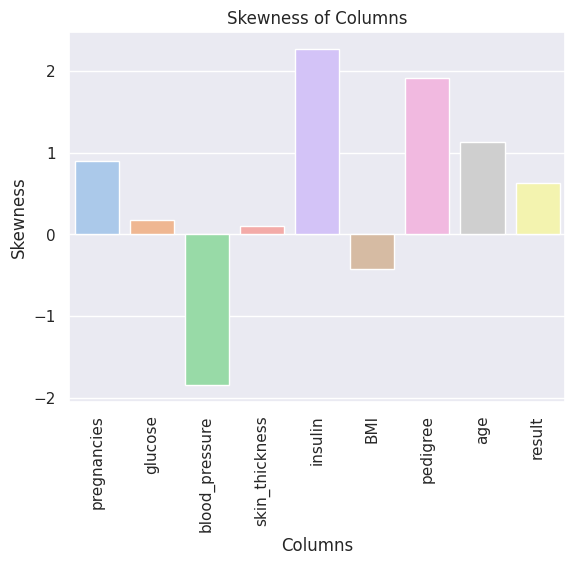

In [15]:
check_skew(data)

### Plot distribution and density curve

In [16]:
def plot_dist_dense(data, n=3):
  fig, axes = plt.subplots(n, n, figsize=(10,10))
  colors = ['blue', 'green', 'orange', 'red', 'purple', 'cyan', 'magenta', 'yellow', 'brown']

  for num, column in enumerate(data.columns):
    row = num // n
    col = num % n
    ax = axes[row, col]
    sns.histplot(data[column], kde=True, color=colors[num], ax=ax)
  plt.tight_layout()
  plt.show()

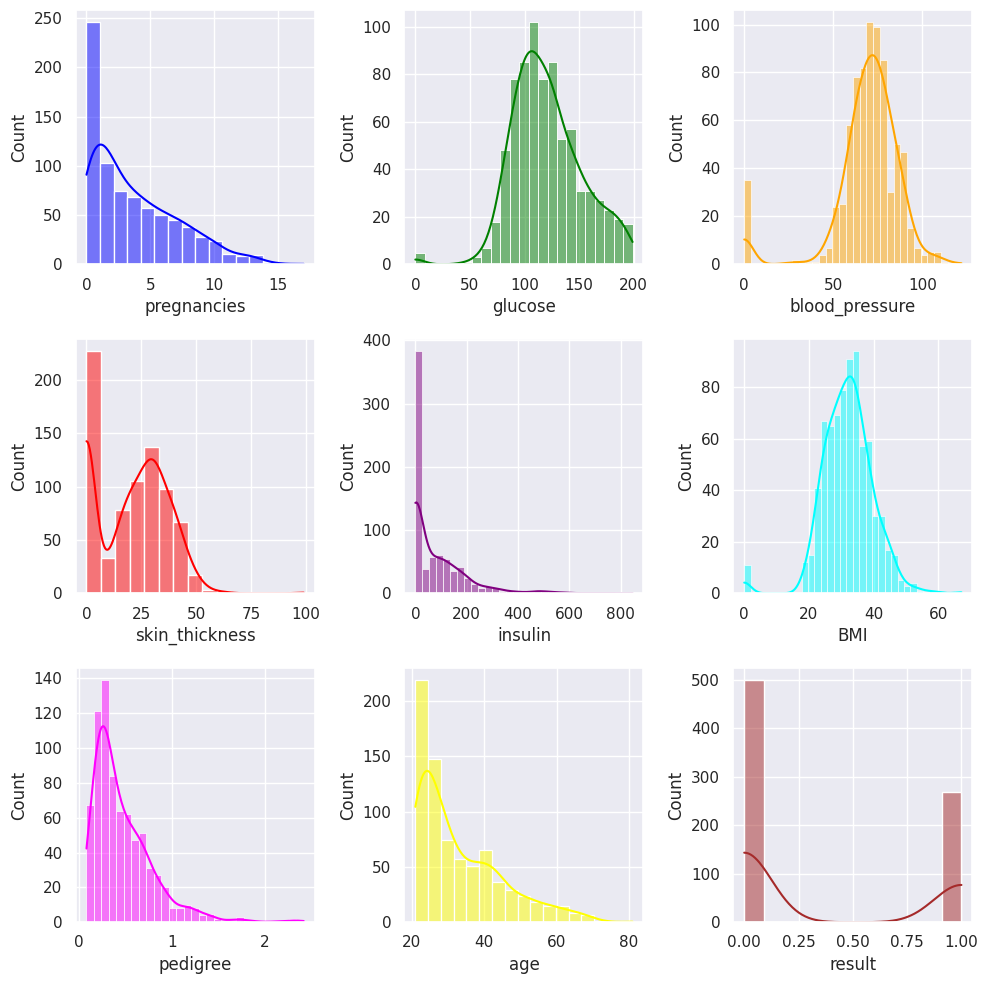

In [17]:
plot_dist_dense(data)

Looks like we got some outliers as well as some BMI, skin_thickness, insulin, blood_pressure and glucose values 0 which is not possible.

### Check which rows (suspicious) got 0 as values

In [18]:
data[(data['insulin']==0) | (data['BMI']==0) | (data['skin_thickness']==0) | (data['blood_pressure']==0) | (data['glucose']==0)]

pregnancies  glucose  blood_pressure  skin_thickness  insulin   BMI  \
0              6      148              72              35        0  33.6   
1              1       85              66              29        0  26.6   
2              8      183              64               0        0  23.3   
5              5      116              74               0        0  25.6   
7             10      115               0               0        0  35.3   
..           ...      ...             ...             ...      ...   ...   
761            9      170              74              31        0  44.0   
762            9       89              62               0        0  22.5   
764            2      122              70              27        0  36.8   
766            1      126              60               0        0  30.1   
767            1       93              70              31        0  30.4   

     pedigree  age  result  
0       0.627   50       1  
1       0.351   31       0  
2       0.672   32       1  
5       0.201   30       0  
7       0.134   29       0  
..        ...  ...     ...  
761     0.403   43       1  
762     0.142   33       0  
764     0.340   27       0  
766     0.349   47       1  
767     0.315   23       0  

[376 rows x 9 columns]

It also seems that for the half of the dataset the parameters haven't been taken and empty values have been filled with 0.
Also if we remove all cols but insulin, it will leave us with the same 374 out of 376 with missing data (extra ones go for glucose and BMI each).

One of the options could be taking mean, median, mode or using linear regression on the dataset with nonzero parameters.

## Check for outliers

There is no reason in finding IQR since there are too many zeros, o we'll try to find outliers manually by looking at the hist graph.

In [19]:
data[(data['insulin'] > 500) | (data['skin_thickness']>70) | (data['pedigree'] > 2)]# | (data['BMI']==0) | (data['skin_thickness']==0) | (data['blood_presure']==0) | (data['glucose']==0)]

pregnancies  glucose  blood_pressure  skin_thickness  insulin   BMI  \
4              0      137              40              35      168  43.1   
8              2      197              70              45      543  30.5   
13             1      189              60              23      846  30.1   
228            4      197              70              39      744  36.7   
247            0      165              90              33      680  52.3   
286            5      155              84              44      545  38.7   
370            3      173              82              48      465  38.4   
409            1      172              68              49      579  42.4   
445            0      180              78              63       14  59.4   
579            2      197              70              99        0  34.7   
584            8      124              76              24      600  28.7   
655            2      155              52              27      540  38.7   
753            0      181              88              44      510  43.3   

     pedigree  age  result  
4       2.288   33       1  
8       0.158   53       1  
13      0.398   59       1  
228     2.329   31       0  
247     0.427   23       0  
286     0.619   34       0  
370     2.137   25       1  
409     0.702   28       1  
445     2.420   25       1  
579     0.575   62       1  
584     0.687   52       1  
655     0.240   25       1  
753     0.222   26       1

Just 2% of the dataset so we could safely remove these rows, but it seems that most of those abnormal values result in positive diabetes so the anomalies in data could be not the problem in statistics but a symptom of a disease.

Which means we shouldn't remove them.

#### Also judging by distribution it's not necessary to cut outliers before applying transfromations to columns

In [20]:
def check_outliers(df, name, size=4):
  sns.boxplot(x=df[name], linewidth=2, width=0.5, notch=True, palette='Blues')
  sns.swarmplot(x=df[name], color='black', size=size)

In [21]:
def get_iqr(df, name, iqr=1.5, side=1):
  if side:
    iqr_result = df[name].describe()['75%'] * iqr
    new_df = df[df[name] > iqr_result]
  else:
    iqr_result = df[name].describe()['25%'] / iqr
    new_df = df[df[name] < iqr_result]
  display(new_df)
  return iqr_result

## Address skewness

As pedigree, age, and pregnancies are the only values which don't have zeros or we're ok with that, we'll work with them for now.

#### Let's prepare some code to see the best transformations

In [22]:
transformed_data = data.copy()

In [23]:
def bxcx(df):
  result, _ = boxcox(df+1) #we add one in case of zero values
  return result

In [24]:
def plot_transforms(data, name):
  operations = [np.sqrt, np.cbrt, np.log, np.log1p]
  opernames = ['square root', 'cube root', 'log', 'log1p', 'boxcox']
  colors = ['magenta', 'blue','orange','indigo', 'red']
  fig, axes = plt.subplots(1, 5, figsize=(12,2))
  fig.suptitle(name)

  def plot_in_subplots(result, num):
    sns.histplot(result, kde=True, color = colors[num], ax=axes[num])
    axes[num].set_xlabel(opernames[num])
    axes[num].set_ylabel('')

  for num in range(4):
    result = data[name].apply(lambda x: operations[num](x))
    plot_in_subplots(result, num)

  result = bxcx(data[name])
  plot_in_subplots(result, 4)

### pedigree

Since there are many values between 1 and 0, we were going to apply np.log1p (adding 1), but taking cube root provides better looking bell distribution

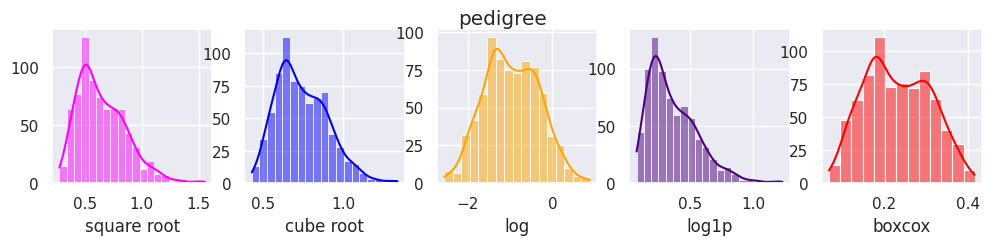

In [25]:
plot_transforms(transformed_data, 'pedigree')

looks like boxcox+1 perfroms better

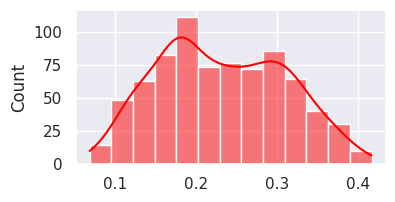

In [26]:
pedigree = data['pedigree'].copy()
pedigree = bxcx(pedigree)
plt.figure(figsize = (4,2))
sns.histplot(pedigree, kde=True, color = 'red')
transformed_data['pedigree'] = pedigree

#### Outliers

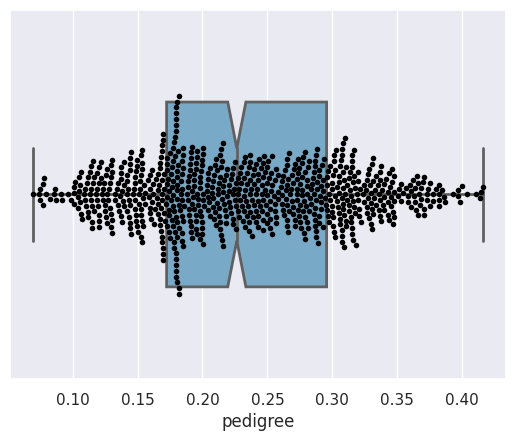

In [27]:
check_outliers(transformed_data, 'pedigree')

### age

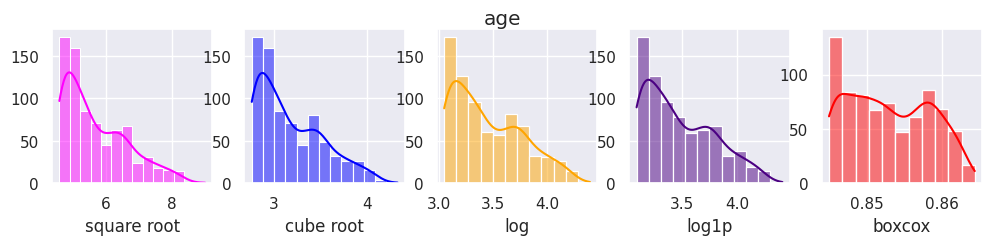

In [28]:
plot_transforms(transformed_data, 'age')

Not much we can do here since the data is very skewed itself, my choice falls on boxcox

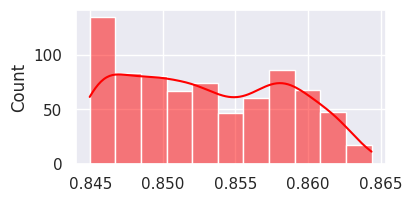

In [29]:
age = data['age'].copy()
age = bxcx(age)
plt.figure(figsize = (4,2))
sns.histplot(age, kde=True, color = 'red')
transformed_data['age'] = age

#### Check for outliers

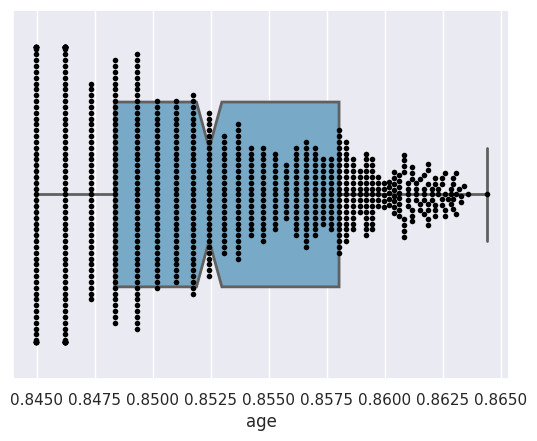

In [30]:
check_outliers(transformed_data, 'age')

In [31]:
get_iqr(transformed_data, 'age')

Empty DataFrame
Columns: [pregnancies, glucose, blood_pressure, skin_thickness, insulin, BMI, pedigree, age, result]
Index: []

1.287039181539684

One outlier (fit in by transformation) won't do much

### Pregnacies

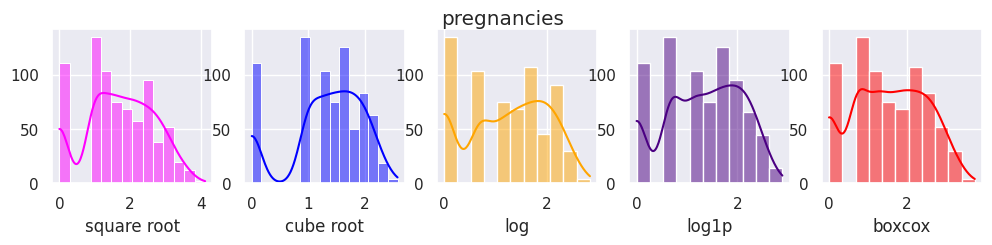

In [32]:
plot_transforms(transformed_data, 'pregnancies')

Not much difference seen here. Let's choose log1p (def not log since we got zeros) for once

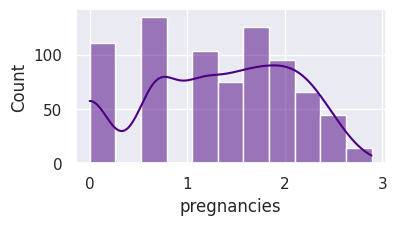

In [33]:
preg = data['pregnancies'].copy()
preg = preg.apply(lambda x: np.log1p(x))
plt.figure(figsize = (4,2))
sns.histplot(preg, kde=True, color='indigo')
transformed_data['pregnancies'] = preg

#### Check for outliers

In [34]:
iqr3 = data['pregnancies'].describe()['75%']*3
data[data['pregnancies'] > iqr3]

Empty DataFrame
Columns: [pregnancies, glucose, blood_pressure, skin_thickness, insulin, BMI, pedigree, age, result]
Index: []

In [35]:
get_iqr(transformed_data, 'pregnancies')

Empty DataFrame
Columns: [pregnancies, glucose, blood_pressure, skin_thickness, insulin, BMI, pedigree, age, result]
Index: []

2.9188652235829697

There are some outliers in original dataset but they don't get into **IQR * 3** so we can leave them be.

6.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


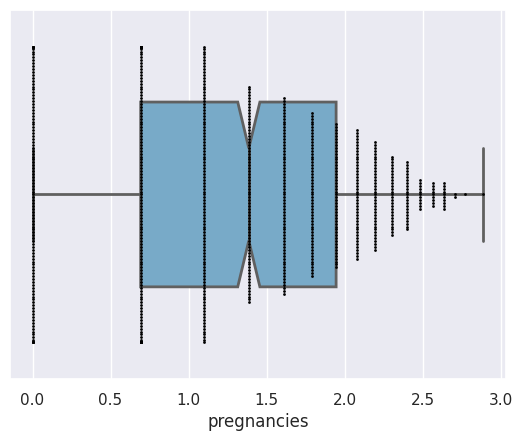

In [36]:
check_outliers(transformed_data, 'pregnancies', 2)

## Fill zero values

In [37]:
def zero_df(df):
  df = pd.DataFrame({'Zeros':df.eq(0).sum()})
  display(df)

In [38]:
zero_df(data)

Zeros
pregnancies       111
glucose             5
blood_pressure     35
skin_thickness    227
insulin           374
BMI                11
pedigree            0
age                 0
result            500

### Glucose

In [39]:
transformed_data[transformed_data['glucose']==0]

pregnancies  glucose  blood_pressure  skin_thickness  insulin   BMI  \
75         0.693        0              48              20        0  24.7   
182        0.693        0              74              20       23  27.7   
342        0.693        0              68              35        0  32.0   
349        1.792        0              80              32        0  41.0   
502        1.946        0              68              41        0  39.0   

     pedigree    age  result  
75      0.113  0.846       0  
182     0.198  0.845       0  
342     0.232  0.846       0  
349     0.217  0.857       1  
502     0.314  0.858       1

since we got just 5 zero values we can simply fill 0 glucose with mean.

In [40]:
gluc_df = transformed_data.copy()
gluc_df['glucose'].replace(0, gluc_df['glucose'].mean(), inplace=True)

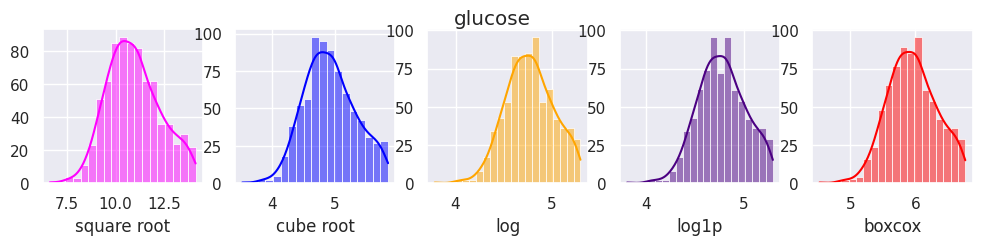

In [41]:
plot_transforms(gluc_df, 'glucose')

Square root transformation looks nice

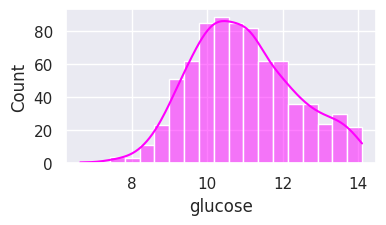

In [42]:
gluc = gluc_df['glucose'].copy()
gluc = gluc.apply(lambda x: np.sqrt(x))
plt.figure(figsize = (4,2))
sns.histplot(gluc, kde=True, color='magenta')
gluc_df['glucose'] = gluc

#### Check for outliers

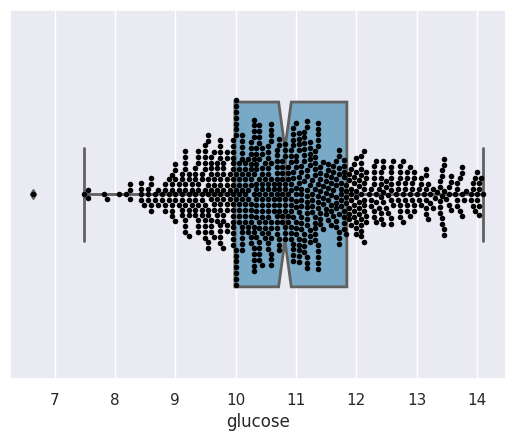

In [43]:
check_outliers(gluc_df, 'glucose')

In [44]:
iqr = get_iqr(gluc_df, 'glucose', 3, side=0)

Empty DataFrame
Columns: [pregnancies, glucose, blood_pressure, skin_thickness, insulin, BMI, pedigree, age, result]
Index: []

One outlier, with no insulin, skin thickness and represents control group with no diabetes. We can drop it.

In [45]:
#gluc_df = gluc_df[gluc_df['glucose'] > iqr]

### BMI


In [46]:
gluc_df[gluc_df['BMI']==0]

pregnancies  glucose  blood_pressure  skin_thickness  insulin  BMI  \
9          2.197   11.180              96               0        0  0.0   
49         2.079   10.247               0               0        0  0.0   
60         1.099    9.165               0               0        0  0.0   
81         1.099    8.602               0               0        0  0.0   
145        0.000   10.100              75              23        0  0.0   
371        0.000   10.863              64              23       89  0.0   
426        0.000    9.695               0               0        0  0.0   
494        1.386    8.944               0               0        0  0.0   
522        1.946   10.677               0               0        0  0.0   
684        1.792   11.662              82               0        0  0.0   
706        2.398   10.724               0               0        0  0.0   

     pedigree    age  result  
9       0.167  0.861       1  
49      0.200  0.848       0  
60      0.200  0.845       0  
81      0.087  0.846       0  
145     0.284  0.845       0  
371     0.398  0.845       0  
426     0.178  0.849       0  
494     0.135  0.846       0  
522     0.143  0.850       0  
684     0.298  0.863       0  
706     0.181  0.853       1

Same here. ~1.5% of all dataset could be filled with means with no issues

In [47]:
bmi_df = gluc_df.copy()
bmi_df['BMI'].replace(0, bmi_df['BMI'].mean(), inplace=True)
bmi_df[bmi_df['BMI']<=0]

Empty DataFrame
Columns: [pregnancies, glucose, blood_pressure, skin_thickness, insulin, BMI, pedigree, age, result]
Index: []

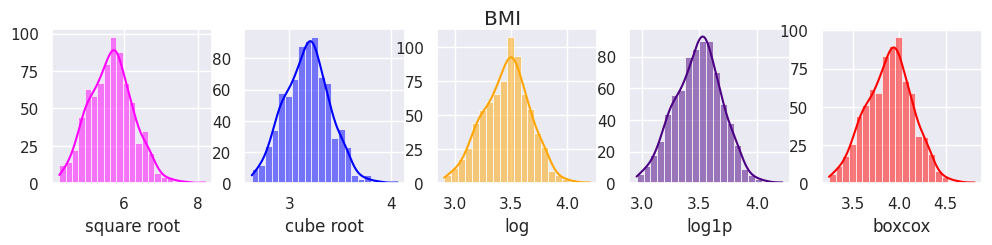

In [48]:
plot_transforms(bmi_df, 'BMI')

Every single one transformation looks nice. Let's do log

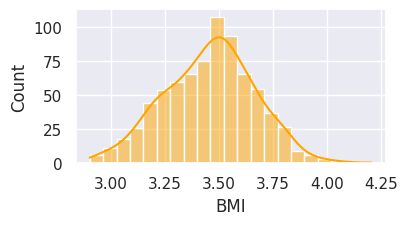

In [49]:
bmi = bmi_df['BMI'].copy()
bmi = bmi.apply(lambda x: np.log(x))
plt.figure(figsize = (4,2))
sns.histplot(bmi, kde=True, color='orange')
bmi_df['BMI'] = bmi

#### Check for outliers

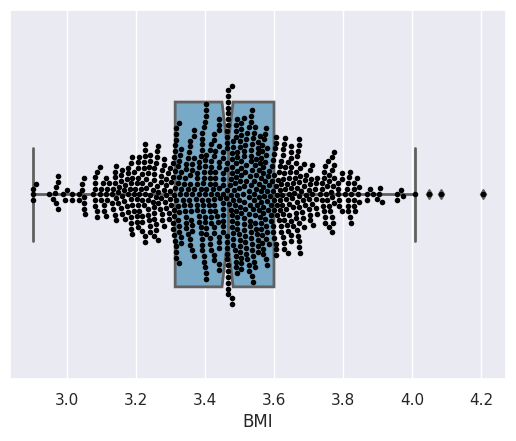

In [50]:
check_outliers(bmi_df, 'BMI')

In [51]:
get_iqr(bmi_df, 'BMI')

Empty DataFrame
Columns: [pregnancies, glucose, blood_pressure, skin_thickness, insulin, BMI, pedigree, age, result]
Index: []

5.400072298074959

Three outliers but they don't go beyond IQR * 1.5 so we're ok with them

### Blood pressure

blood pressure has 35 zero values and we assume that all the test participants were alive. 35 of 768 is coming close to 5% which I'd select as a limit for filling with mean, but 4.5 is lower than 5, so we'll do the same operation here as well.

In [52]:
bp_df = bmi_df.copy()
bp_df['blood_pressure'].replace(0, bp_df['blood_pressure'].mean(), inplace=True)
bp_df[bp_df['blood_pressure']==0]

Empty DataFrame
Columns: [pregnancies, glucose, blood_pressure, skin_thickness, insulin, BMI, pedigree, age, result]
Index: []

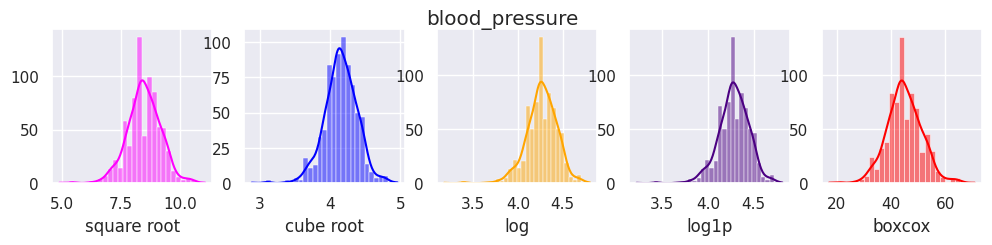

In [53]:
plot_transforms(bp_df, 'blood_pressure')

Looks like cube root is a winner, smoothing outliers (and fit outlier into iqr1.5)

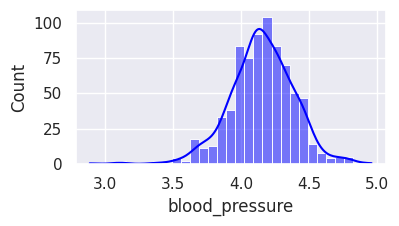

In [54]:
bp = bp_df['blood_pressure'].copy()
bp = bp.apply(lambda x: np.cbrt(x))
plt.figure(figsize = (4,2))
sns.histplot(bp, kde=True, color='blue')
bp_df['blood_pressure'] = bp

#### Check for outliers

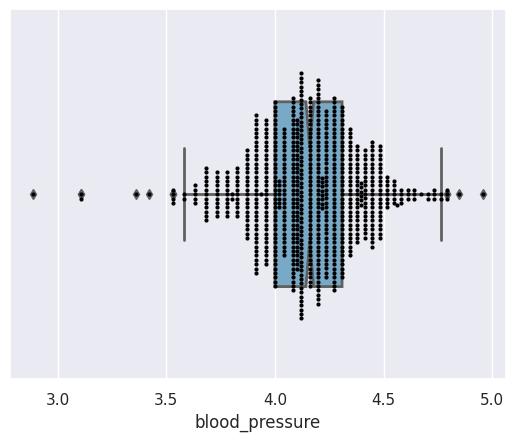

In [55]:
check_outliers(bp_df, 'blood_pressure', 3)

In [56]:
get_iqr(bp_df, 'blood_pressure')

Empty DataFrame
Columns: [pregnancies, glucose, blood_pressure, skin_thickness, insulin, BMI, pedigree, age, result]
Index: []

6.46330407009565

In [57]:
get_iqr(bp_df, 'blood_pressure', side=0)

Empty DataFrame
Columns: [pregnancies, glucose, blood_pressure, skin_thickness, insulin, BMI, pedigree, age, result]
Index: []

2.6666666666666665

Some people got low blood pressure but nothing special that would go below IQR/1.5 on cube root (one gows on square root though)

## Predict empty (0) parameters

In [58]:
zero_df(bp_df)

Zeros
pregnancies       111
glucose             0
blood_pressure      0
skin_thickness    227
insulin           374
BMI                 0
pedigree            0
age                 0
result            500

Now we got two parameters - insulin and skin_thinkness we need to fill. Since there are too many empty values we can't fill them with mean or median, so, we could use a linear regression to approximate the values.

### Skin thickness

In [59]:
bp_df[(bp_df['insulin']==0) & (bp_df['skin_thickness']==0)]

pregnancies  glucose  blood_pressure  skin_thickness  insulin    BMI  \
2          2.197   13.528           4.000               0        0  3.148   
5          1.792   10.770           4.198               0        0  3.243   
7          2.398   10.724           4.104               0        0  3.564   
9          2.197   11.180           4.579               0        0  3.466   
10         1.609   10.488           4.514               0        0  3.627   
..           ...      ...             ...             ...      ...    ...   
757        0.000   11.091           4.160               0        0  3.592   
758        0.693   10.296           4.236               0        0  3.624   
759        1.946   13.784           4.514               0        0  3.570   
762        2.303    9.434           3.958               0        0  3.114   
766        0.693   11.225           3.915               0        0  3.405   

     pedigree    age  result  
2       0.305  0.854       1  
5       0.150  0.853       0  
7       0.110  0.852       0  
9       0.167  0.861       1  
10      0.145  0.853       0  
..        ...    ...     ...  
757     0.179  0.861       1  
758     0.148  0.850       0  
759     0.189  0.863       1  
762     0.115  0.855       0  
766     0.218  0.860       1  

[227 rows x 9 columns]

As we can see if the insulin is not measured, the skin_thinkness is not measured as well

In [60]:
get_iqr(bp_df, 'skin_thickness', 3)

pregnancies  glucose  blood_pressure  skin_thickness  insulin    BMI  \
579        1.099   14.036           4.121              99        0  3.547   

     pedigree    age  result  
579     0.284  0.862       1

96.0

Skin thickness 99 is clearly a mistake. So let's set it to 0 and predict it from anew.

In [61]:
bp_df.at[579, 'skin_thickness'] = 0
bp_df.loc[579]

pregnancies        1.099
glucose           14.036
blood_pressure     4.121
skin_thickness     0.000
insulin            0.000
BMI                3.547
pedigree           0.284
age                0.862
result             1.000
Name: 579, dtype: float64

#### Split into test and train datasets, extract Xs and ys

In [62]:
skin_df = bp_df.drop(['insulin'], axis=1)

test_skin_df = skin_df[skin_df['skin_thickness'] == 0]
X_test_skin = test_skin_df.drop(['skin_thickness'], axis=1)

train_skin_df = skin_df[skin_df['skin_thickness'] > 0]
X_train_skin = train_skin_df.drop(['skin_thickness'], axis=1)
y_train_skin = train_skin_df['skin_thickness']

#### Create a model

In [63]:
skin_model = LinearRegression()

#### Create cross-validation

In [64]:
skin_cv = KFold(n_splits=5, random_state=13, shuffle=True)

In [65]:
skin_score = (-cross_val_score(skin_model, X_train_skin, y_train_skin, cv=skin_cv, scoring = 'neg_mean_squared_error')).mean()
print('mse:', round(skin_score, 2), '\nmae:', round(skin_score**.5, 2))

mse: 55.23 
mae: 7.43


So average mistake is about 7.5. 10-15% is ok for our needs

#### Train model

In [66]:
mse_cv_sk = []
for train_idx, val_idx in skin_cv.split(X_train_skin):
  X_train_sk, X_val_sk = X_train_skin.iloc[train_idx], X_train_skin.iloc[val_idx]
  y_train_sk, y_val_sk = y_train_skin.iloc[train_idx], y_train_skin.iloc[val_idx]

  skin_model.fit(X_train_sk, y_train_sk)
  y_pred_sk = skin_model.predict(X_val_sk)
  mse_sk = mean_squared_error(y_val_sk, y_pred_sk)
  mse_cv_sk.append(mse_sk)

avg_mse = np.mean(mse_cv_sk)
print('Mean MSE:', avg_mse)

Mean MSE: 55.22693648114934


#### Predict

In [67]:
pred_skin = skin_model.predict(X_test_skin)

#### Combine dataset together

In [68]:
dfsk = X_test_skin.copy()
dfsk['skin_thickness'] = np.round(pred_skin).astype("int32")
dfsk = dfsk[train_skin_df.columns]

thick_df = pd.concat([train_skin_df, dfsk])
thick_df = thick_df.sort_index().reset_index(drop=True)

In [69]:
thick_df

pregnancies  glucose  blood_pressure  skin_thickness    BMI  pedigree  \
0          1.946   12.166           4.160              35  3.515     0.296   
1          0.693    9.220           4.041              29  3.281     0.219   
2          2.197   13.528           4.000              19  3.148     0.305   
3          0.693    9.434           4.041              23  3.336     0.130   
4          0.000   11.705           3.420              35  3.764     0.414   
..           ...      ...             ...             ...    ...       ...   
763        2.398   10.050           4.236              48  3.493     0.133   
764        1.099   11.045           4.121              27  3.605     0.214   
765        1.792   11.000           4.160              23  3.266     0.173   
766        0.693   11.225           3.915              27  3.405     0.218   
767        0.693    9.644           4.121              31  3.414     0.204   

       age  result  
0    0.860       1  
1    0.854       0  
2    0.854       1  
3    0.845       0  
4    0.855       1  
..     ...     ...  
763  0.863       0  
764  0.851       0  
765  0.853       0  
766  0.860       1  
767  0.847       0  

[768 rows x 8 columns]

### Insulin

#### Split for test and train

In [70]:
ins_df = bp_df.copy()
ins_df['skin_thickness'] = thick_df['skin_thickness']

train_ins = ins_df[ins_df['insulin'] > 0]
test_ins = ins_df[ins_df['insulin'] == 0]

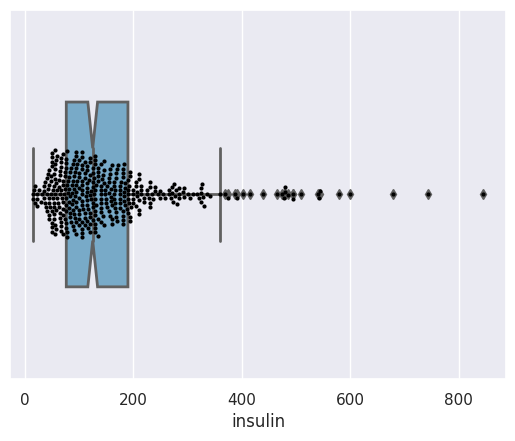

In [71]:
check_outliers(train_ins, 'insulin', 3)

<Axes: xlabel='insulin', ylabel='Count'>

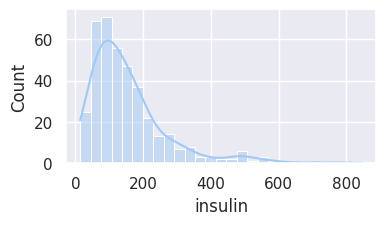

In [72]:
plt.figure(figsize=(4,2))
sns.histplot(train_ins['insulin'], kde=True)

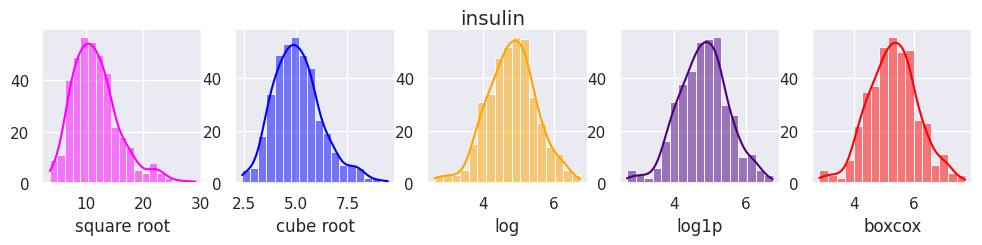

In [73]:
plot_transforms(train_ins, 'insulin')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


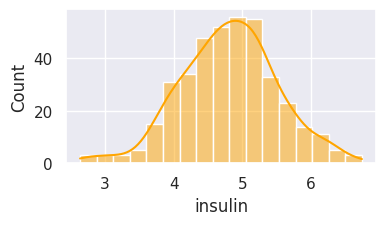

In [74]:
ins = train_ins['insulin'].copy()
ins = ins.apply(lambda x: np.log(x))
plt.figure(figsize = (4,2))
sns.histplot(ins, kde=True, color='orange')
train_ins['insulin'] = ins

In [75]:
get_iqr(train_ins, 'insulin')

Empty DataFrame
Columns: [pregnancies, glucose, blood_pressure, skin_thickness, insulin, BMI, pedigree, age, result]
Index: []

7.87053610824073

#### Split for X and target data

In [76]:
X_train_ins = train_ins.drop(['insulin'], axis=1)
y_train_ins = train_ins['insulin']

X_test_ins = test_ins.drop(['insulin'], axis=1)
y_test_ins = test_ins['insulin']

#### Split for train and val datasets

In [77]:
X_ins_train, X_ins_val, y_ins_train, y_ins_val = train_test_split(X_train_ins, y_train_ins, test_size=0.2, random_state=42)

#### Apply Scaler

In [78]:
scaler = StandardScaler()

X_i_train_scaled = scaler.fit_transform(X_ins_train)
X_i_val_scaled = scaler.transform(X_ins_val)
X_i_test_scaled = scaler.transform(X_test_ins)

#### Create and train model

In [79]:
ins_model = RidgeCV(alphas=[0.1, 1, 10.0])
ins_model.fit(X_i_train_scaled, y_ins_train)

RidgeCV(alphas=[0.1, 1, 10.0])

In [80]:
ins_model.alpha_

10.0

In [81]:
r2_ins = round(ins_model.score(X_i_val_scaled, y_ins_val), 3)
y_val_pred_i = ins_model.predict(X_i_val_scaled)
mse_ins = mean_squared_error(y_val_pred_i, y_ins_val)
print(f'R2 score:{r2_ins}\nMSE: {round(mse_ins,2)}\nMAE: {round(mse_ins**0.5, 2)}')

R2 score:0.472
MSE: 0.27
MAE: 0.52


#### Try RandomForest

In [82]:
ins_model2 = RandomForestRegressor(n_estimators=100, max_depth=3)
ins_model2.fit(X_i_train_scaled, y_ins_train)
y_val_i_forest = ins_model2.predict(X_i_val_scaled)
mse_ins_forest = mean_squared_error(y_val_i_forest, y_ins_val)
print(f'MSE: {round(mse_ins_forest, 2)}\nMAE: {round(mse_ins_forest**0.5, 2)}')

MSE: 0.27
MAE: 0.52


Terrible result (look at r2) but still better than using mean.

#### Predict

In [83]:
pred_ins = ins_model.predict(X_i_test_scaled)

In [84]:
dfi = X_test_ins.copy()
dfi['insulin'] = pred_ins
df = pd.concat([train_ins, dfi])
df = df.sort_index().reset_index(drop=True)
df = df[data.columns]
df

pregnancies  glucose  blood_pressure  skin_thickness  insulin    BMI  \
0          1.946   12.166           4.160              35    5.246  3.515   
1          0.693    9.220           4.041              29    4.197  3.281   
2          2.197   13.528           4.000              19    5.403  3.148   
3          0.693    9.434           4.041              23    4.543  3.336   
4          0.000   11.705           3.420              35    5.124  3.764   
..           ...      ...             ...             ...      ...    ...   
763        2.398   10.050           4.236              48    5.193  3.493   
764        1.099   11.045           4.121              27    4.892  3.605   
765        1.792   11.000           4.160              23    4.718  3.266   
766        0.693   11.225           3.915              27    4.928  3.405   
767        0.693    9.644           4.121              31    4.324  3.414   

     pedigree    age  result  
0       0.296  0.860       1  
1       0.219  0.854       0  
2       0.305  0.854       1  
3       0.130  0.845       0  
4       0.414  0.855       1  
..        ...    ...     ...  
763     0.133  0.863       0  
764     0.214  0.851       0  
765     0.173  0.853       0  
766     0.218  0.860       1  
767     0.204  0.847       0  

[768 rows x 9 columns]

## Have a look at the transfromed data

In [85]:
df = convert_dtype(df)

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pregnancies     768 non-null    float32
 1   glucose         768 non-null    float32
 2   blood_pressure  768 non-null    float32
 3   skin_thickness  768 non-null    int32  
 4   insulin         768 non-null    float32
 5   BMI             768 non-null    float32
 6   pedigree        768 non-null    float32
 7   age             768 non-null    float32
 8   result          768 non-null    int32  
dtypes: float32(7), int32(2)
memory usage: 27.1 KB


In [87]:
df.describe()

pregnancies  glucose  blood_pressure  skin_thickness  insulin      BMI  \
count      768.000  768.000         768.000         768.000  768.000  768.000   
mean         1.311   10.946           4.152          28.600    4.792    3.458   
std          0.770    1.365           0.237           9.271    0.583    0.211   
min          0.000    6.633           2.884           7.000    2.639    2.901   
25%          0.693    9.987           4.000          22.000    4.431    3.314   
50%          1.386   10.817           4.160          28.000    4.780    3.466   
75%          1.946   11.843           4.309          35.000    5.165    3.600   
max          2.890   14.107           4.960          63.000    6.741    4.206   

       pedigree      age   result  
count   768.000  768.000  768.000  
mean      0.232    0.853    0.349  
std       0.078    0.005    0.477  
min       0.069    0.845    0.000  
25%       0.172    0.848    0.000  
50%       0.226    0.852    0.000  
75%       0.296    0.858    1.000  
max       0.416    0.864    1.000

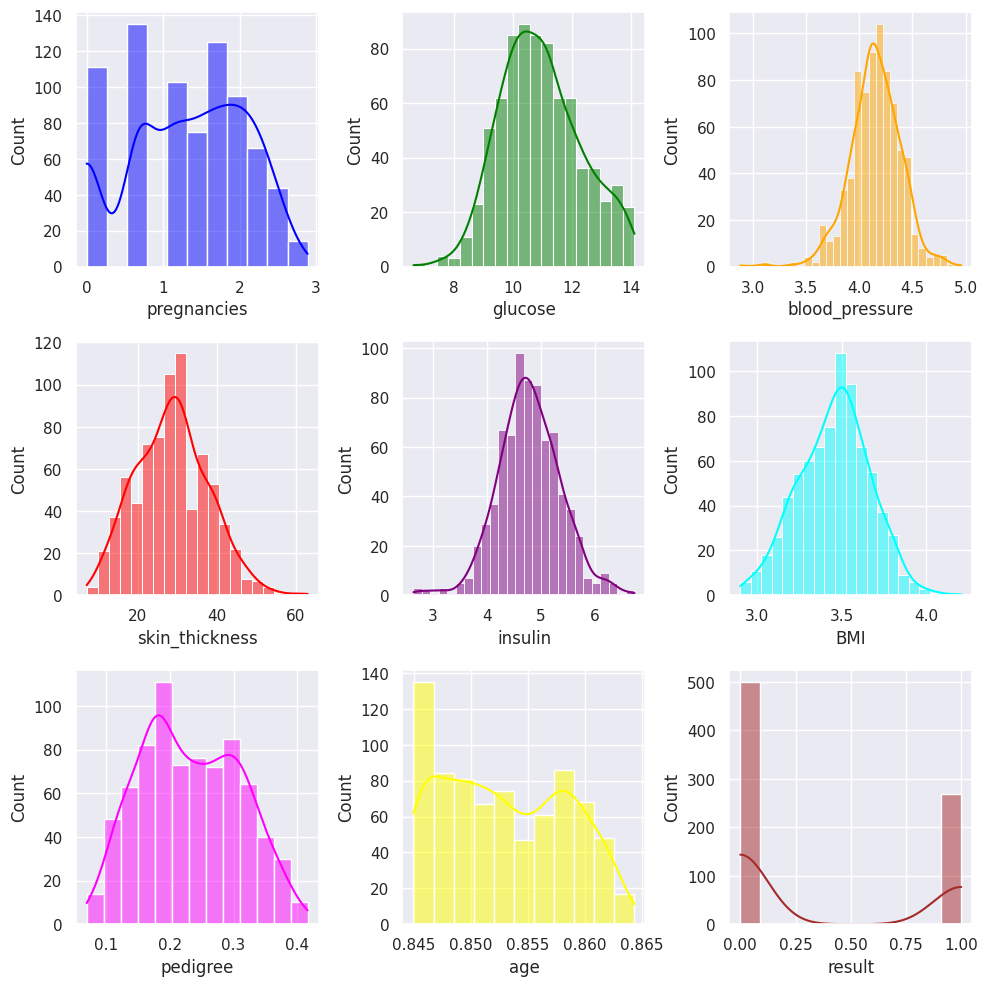

In [88]:
plot_dist_dense(df)

Looking a bit more gaussian now

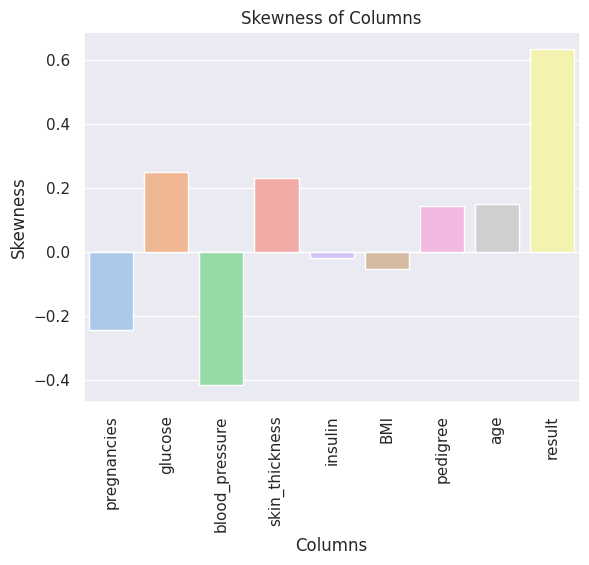

In [89]:
check_skew(df)

Well, from -2 to 2 we got to -0.4 to 0.2

### Check for relationships once more

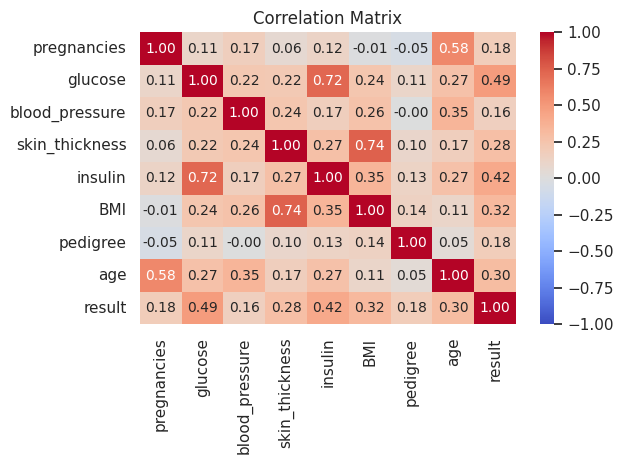

In [90]:
corrs = df.corr()

sns.heatmap(corrs, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', annot_kws={'size': 10})
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

And now we see high correlation between glucose and insulin as well as between BMI and skin_thickness (no wonder since we filled zeros using the regression which takes those values into account)

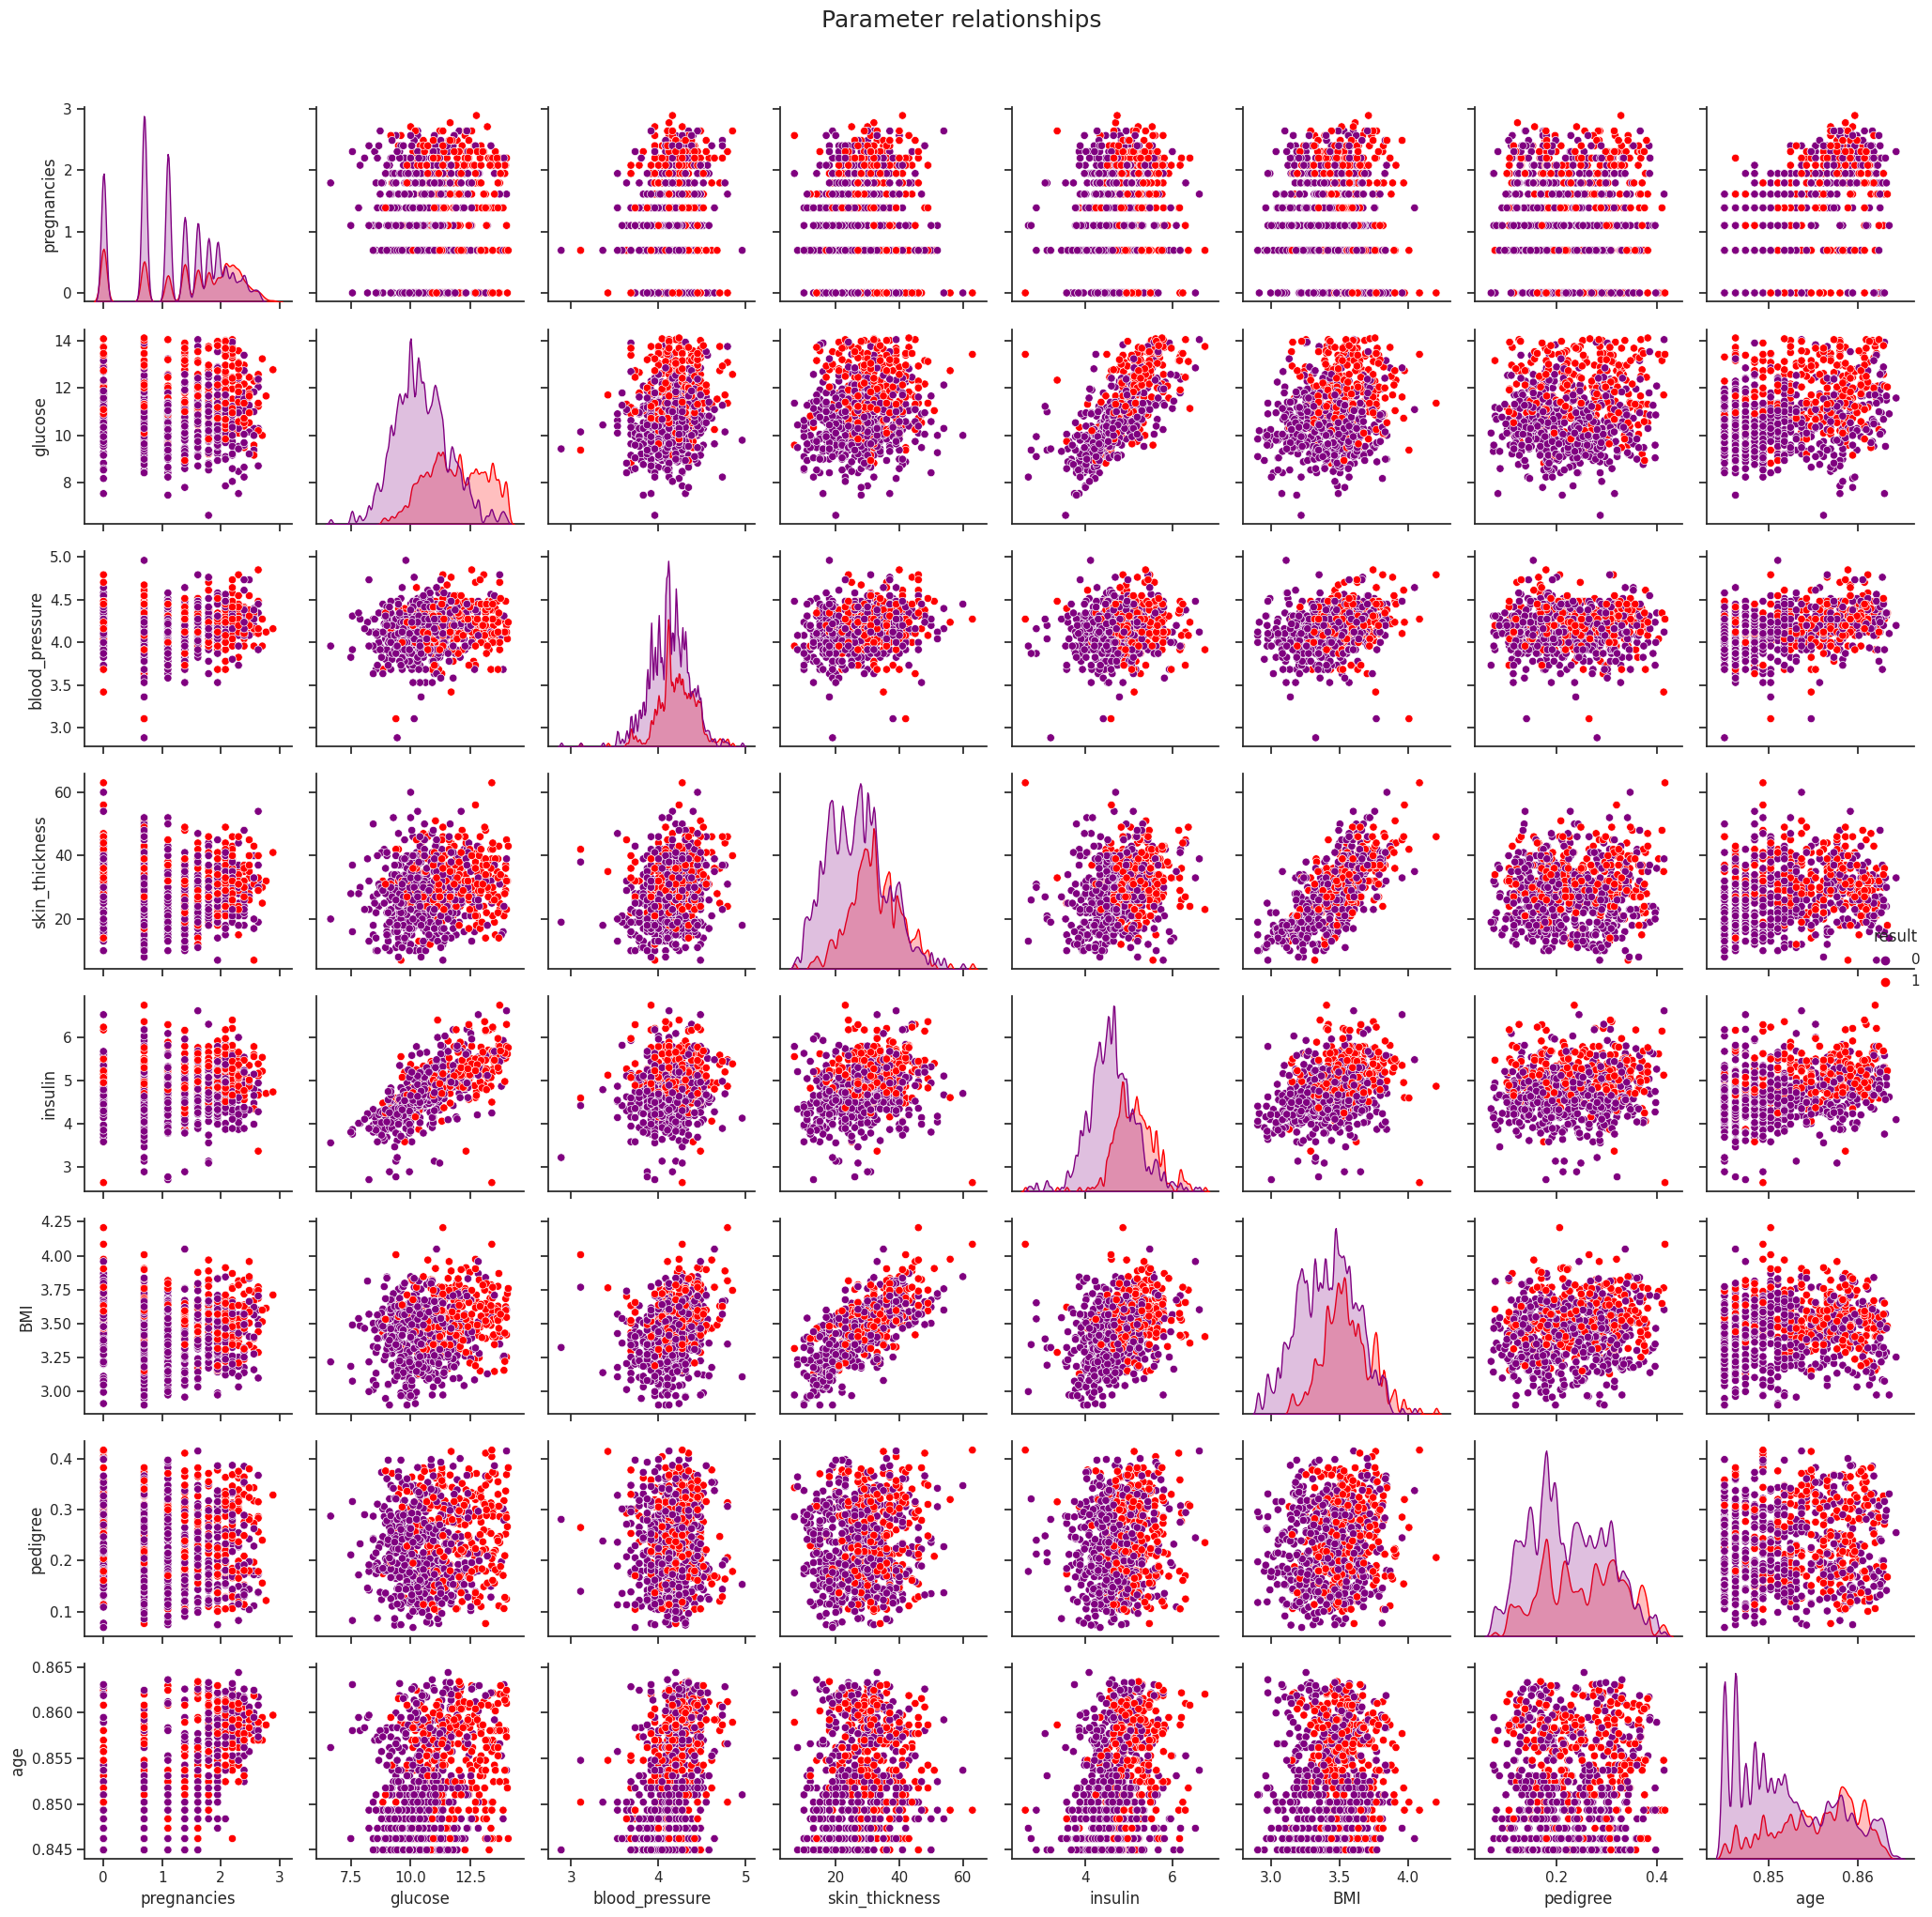

In [91]:
sns.set(style="ticks", color_codes=True)
palette = ['purple', 'red']#sns.color_palette("husl")
sns.pairplot(df, diag_kind="kde", hue="result", palette=palette, markers='o', diag_kws={'bw_adjust': 0.2})
plt.suptitle("Parameter relationships", y=1.02, fontsize=18)
sns.despine()
plt.tight_layout()
plt.show()

# Check for most important parameters

In [92]:
def get_xy(df):
  df = df.copy()
  X = df.drop(['result'], axis=1)
  y = df['result']
  return X, y

### Select K best

#### Chi2

Since we have a classification task, we are going to use chi-squared as statistical test for feature selection

In [93]:
def get_kbest(df):
  X, y = get_xy(df)
  kbest = SelectKBest(score_func=chi2, k=4)
  kbest_trained = kbest.fit(X, y)
  return kbest_trained

In [94]:
def get_kbest_chi2_score(df):
  X, y = get_xy(df)
  kbest = SelectKBest(score_func=chi2, k=4)
  kbest_trained = kbest.fit(X, y)
  kbest_dict = dict(zip(df.columns[:-1], np.round(kbest_trained.scores_, 3)))
  sorted_kbest = dict(sorted(kbest_dict.items(), key=lambda i: i[1], reverse=True))

  print('Scores assigned by chi squared:')
  for col, val in sorted_kbest.items():
    print(f'{col}: {val}')
  print()

  print('Values of top most important features')
  features = kbest.transform(X)
  print(features[0:5, :])

In [95]:
def compare_kbest(data1, data2):
  df1 = get_kbest(data1)
  df2 = get_kbest(data2)
  kbest_dict = pd.DataFrame(zip(np.round(df1.scores_, 3),
                                np.round(df2.scores_, 3)), index = data1.columns[:8],
                            columns =['data', 'transformed data']).sort_values(
                                by='transformed data', ascending=False)
  display(kbest_dict)

In [96]:
get_kbest_chi2_score(data)

Scores assigned by chi squared:
insulin: 2175.565
glucose: 1411.887
age: 181.304
BMI: 127.669
pregnancies: 111.52
skin_thickness: 53.108
blood_pressure: 17.605
pedigree: 5.393

Values of top most important features
[[148.           0.          33.59999847  50.        ]
 [ 85.           0.          26.60000038  31.        ]
 [183.           0.          23.29999924  32.        ]
 [ 89.          94.          28.10000038  21.        ]
 [137.         168.          43.09999847  33.        ]]


In [97]:
get_kbest_chi2_score(df)

Scores assigned by chi squared:
skin_thickness: 182.432
glucose: 31.244
pregnancies: 11.204
insulin: 9.404
BMI: 1.015
pedigree: 0.651
blood_pressure: 0.27
age: 0.002

Values of top most important features
[[ 1.9459101  12.16552544 35.          5.24610519]
 [ 0.69314718  9.21954441 29.          4.19664431]
 [ 2.19722462 13.52774906 19.          5.40263033]
 [ 0.69314718  9.43398094 23.          4.54329491]
 [ 0.         11.70469952 35.          5.12396383]]


In [98]:
compare_kbest(data, df)

data  transformed data
skin_thickness    53.108           182.432
glucose         1411.887            31.244
pregnancies      111.520            11.204
insulin         2175.565             9.404
BMI              127.669             1.015
pedigree           5.393             0.651
blood_pressure    17.605             0.270
age              181.304             0.002

As it seems after all of the transformations and filling of zero values, the age importance has gone down completely, and skin thickness has grown a lot. It's ok since we've already normalized the data.

### RFE

Selecting most influential attributes by recursively fitting the model and removing the lest important features until we get to the set Nth number.

In [99]:
def get_rfe(df, n_features=3):
  X, y = get_xy(df)
  model = LogisticRegression(max_iter=300)
  rfe = RFE(model, n_features_to_select=n_features)
  trained_rfe = rfe.fit(X, y)
  return trained_rfe

In [100]:
df_rfe = get_rfe(df)
data_rfe = get_rfe(data)

rfe_stats = pd.DataFrame(zip(df_rfe.ranking_, data_rfe.ranking_, df_rfe.support_,  data_rfe.support_),
                         index = df.columns[:-1], columns=['DF ranking', 'DATA ranking', 'DF feature', 'DATA feature']
                         ).sort_values(by='DF ranking')
rfe_stats

DF ranking  DATA ranking  DF feature  DATA feature
glucose                  1             2        True         False
BMI                      1             1        True          True
pedigree                 1             1        True          True
pregnancies              2             1       False          True
insulin                  3             5       False         False
age                      4             3       False         False
blood_pressure           5             4       False         False
skin_thickness           6             6       False         False

I assume since there were plenty of zero glucose and insulin data in original the dataset, the algorithm set them to less valuable.

Overall, I'd say that the components a selected porperly, given zeros in original dataset.

### PCA

In [101]:
def get_pca(df, n=3):
  X, y = get_xy(df)
  pca = PCA(n_components=n)
  pca_fit = pca.fit(X, y)
  pca_trans = pca.transform(X)
  return pca_fit, pca_trans

In [102]:
def visualize_pca(df, pca_components=3):
  pca_fit, pca_t = get_pca(df, pca_components)
  pca_df = pd.DataFrame(data=pca_t, columns=['PC1', 'PC2', 'PC3'])

  components_df = pd.DataFrame(pca_fit.components_, index=[f"Component {i+1}" for i in range(pca_components)], columns=df.columns[:-1])
  display(components_df)

  sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=pca_df['PC3'])
  plt.show()

pregnancies  glucose  blood_pressure  skin_thickness  insulin  \
Component 1       -0.002    0.098           0.016           0.061    0.993   
Component 2       -0.023   -0.972          -0.142           0.058    0.095   
Component 3       -0.022    0.143          -0.922          -0.307    0.021   

               BMI   pedigree    age  
Component 1  0.014  5.372e-04 -0.004  
Component 2 -0.047 -8.168e-04 -0.140  
Component 3 -0.132 -6.400e-04 -0.125

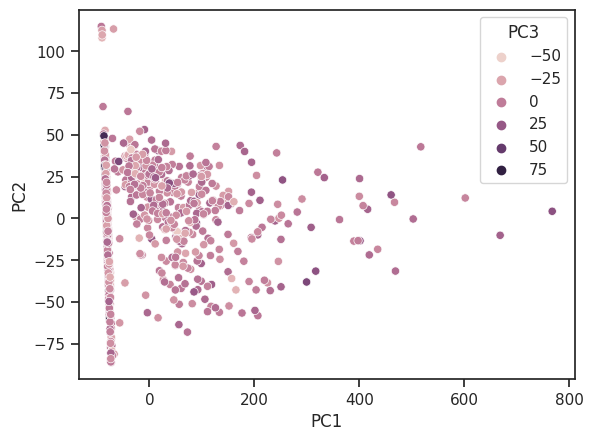

pregnancies  glucose  blood_pressure  skin_thickness  insulin  \
Component 1        0.005    0.033           0.006           0.999    0.018   
Component 2       -0.077   -0.947          -0.030           0.037   -0.308   
Component 3       -0.995    0.084          -0.043           0.003   -0.004   

               BMI   pedigree        age  
Component 1  0.017  8.075e-04  1.005e-04  
Component 2 -0.013 -5.079e-03 -1.050e-03  
Component 3  0.021  6.953e-03 -3.830e-03

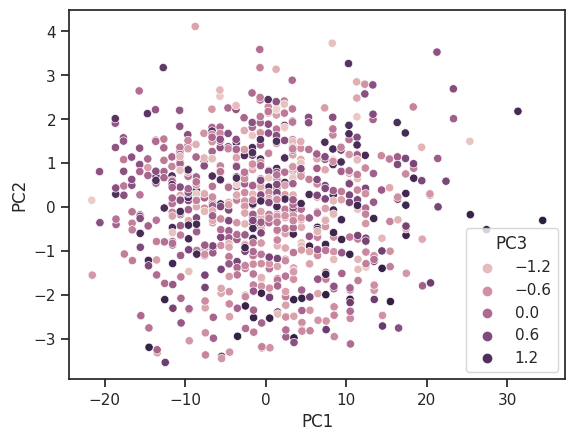

In [103]:
for dataframe in [data, df]:
  visualize_pca(dataframe)

Interestingly, PCA on raw data assumes most important component as insulin with glucose and blood pressure (lowering it) which seems legit and, besides having lots of zeros are heteroscedastically distributed, whereas the transformed data, as in case with k-best using chi square, although components being distributed more homoscedastically (also considering bias and variance) set skin thinckness as most important value with glucose and pregnancies lowering it.

### Extreamly Randomized Trees

ExtRa trees is pretty robust with noisy data, has low bias and (more ofthen than not) variance, and provides an estimate of feature importances based on the number of times the feature was selected by decision trees during training.

In [104]:
def extratree_components(df, title):
  X,y = get_xy(df)
  model = ExtraTreesClassifier()
  model.fit(X,y)
  treedf = pd.DataFrame(model.feature_importances_.reshape(1,-1), columns = df.columns[:-1], index=title)
  return treedf

In [105]:
df1 = extratree_components(data, ['original data'])
df2 = extratree_components(df, ['transformed data'])
pd.concat([df1, df2])

pregnancies  glucose  blood_pressure  skin_thickness  \
original data           0.107    0.238           0.097           0.078   
transformed data        0.094    0.206           0.086           0.108   

                  insulin    BMI  pedigree    age  
original data       0.076  0.142     0.118  0.143  
transformed data    0.151  0.122     0.102  0.131

The ExtraTreesClassifier shows pretty similar model importances for both models with insuling playing more important role in transformed data (again, zeros removed). Maybe using Random forest as model for target prediction would be a good choice.

### Permutation importances

Permutation importance shuffle values of a single feature while keepeng other features unchanged.

In [106]:
def permute(model, X, y):
  score = model.score(X, y)
  feature_importance = {}
  for feature in X.columns:
    X_perm = X.copy()
    X_perm[feature] = np.random.permutation(X_perm[feature])
    perm_score = model.score(X_perm, y)
    feature_importance[feature] = score - perm_score
  return feature_importance

In [107]:
def get_permutations(df, model):
  X, y = get_xy(df)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  model.fit(X_train, y_train)
  permimp = permute(model, X_test, y_test)
  return permimp

In [108]:
def compare_permutes(df1, df2, model):
  dic1 = get_permutations(df1, model)
  dic2 = get_permutations(df2, model)
  result = pd.DataFrame([(dic1[n], dic2[n]) for n in df.columns[:-1]],
                        index = df.columns[:-1], columns = [
                            'original data', 'transformed data']).T
  display(result)

In [109]:
print('Logistic Regression')
compare_permutes(data, df, LogisticRegression(max_iter=300))
print('\nRandom Forest')
compare_permutes(data, df, RandomForestClassifier())

Logistic Regression


pregnancies  glucose  blood_pressure  skin_thickness  \
original data          -0.013    0.123           0.039           0.006   
transformed data       -0.013    0.208           0.006           0.026   

                  insulin    BMI  pedigree    age  
original data       0.006  0.026     0.013 -0.032  
transformed data    0.006  0.000     0.019  0.000


Random Forest


pregnancies  glucose  blood_pressure  skin_thickness  \
original data           0.006    0.130           0.000           0.006   
transformed data        0.019    0.078          -0.006           0.006   

                  insulin    BMI  pedigree  age  
original data      -0.006  0.013     0.006  0.0  
transformed data    0.000  0.032    -0.013  0.0

So negative values mean that the feature had a positive impact on model while being unchanged - in original form, and positive values mean that removing or shuffling the feature had a positive impact on the model.

### SHAP values

Behold the almighty SHAP that considers contribution of each feature to the result using game theory.

In [110]:
def get_shap(df):
  X, y = get_xy(df)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  model = RandomForestClassifier(n_estimators=50, max_depth=7, random_state=42)
  model.fit(X_train, y_train)
  explainer = shap.TreeExplainer(model)
  shap_values = explainer.shap_values(X_test)
  shap.summary_plot(shap_values[1], X_test, plot_type = 'bar', title='TEXT') #somehow title='text' is not shown on the graph

Original data


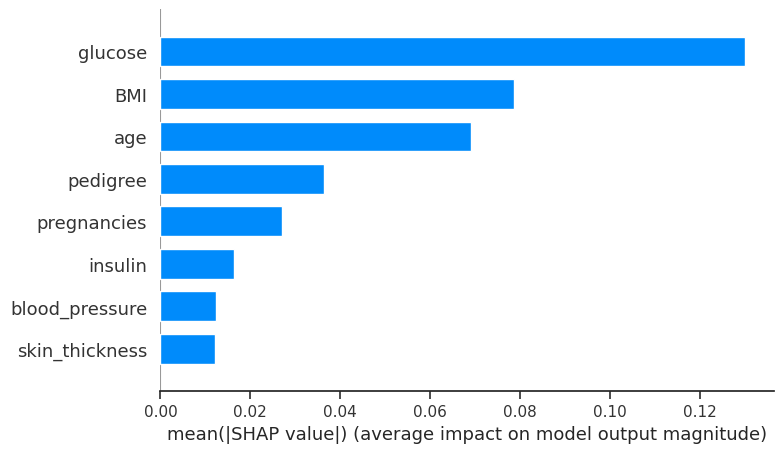

Transformed data


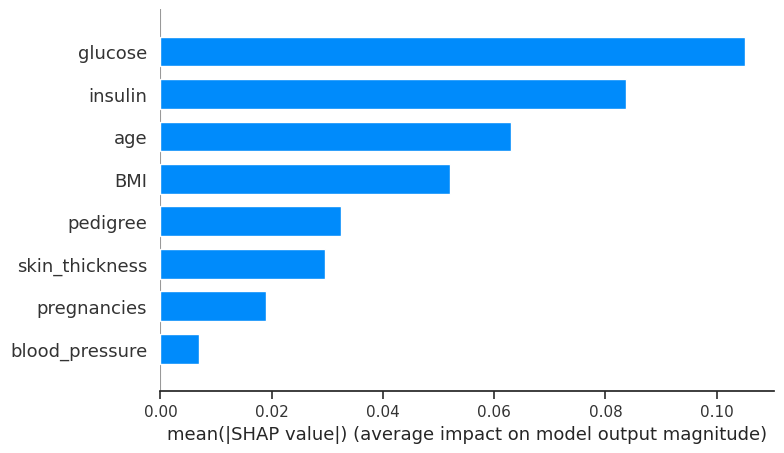

In [111]:
print('Original data')
get_shap(data)
print('Transformed data')
get_shap(df)

Well, as expected glucose and insulin play an important part. Interestingly pedigree func that is calculated by taking into account age and ancestors with diabetes is lower than, say, body mass index.

#Predict and evaluate the data transformations

In [180]:
def traintest(df):
  X, y = get_xy(df)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  model = LogisticRegression(max_iter=400)
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)
  eval_model(y_test, y_pred)


def eval_model(y_pred, y_test):
  print(f'Accuracy: {round(100*accuracy_score(y_test, y_pred), 2)}%\n')

  print('Classification report:')
  cr=classification_report(y_test, y_pred, output_dict=True)
  show_cr(cr)
  show_cm(confusion_matrix(y_test, y_pred))


In [188]:
def highlight_best(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

def show_cr(cr):
  report = pd.DataFrame(cr).transpose()
  report = report.round(2)
  report.style.apply(highlight_best, axis=1)
  display(report)

### Show statistics on raw data

Accuracy: 74.68%

Classification report:


precision  recall  f1-score  support
0                  0.79    0.81      0.80    96.00
1                  0.67    0.64      0.65    58.00
accuracy           0.75    0.75      0.75     0.75
macro avg          0.73    0.73      0.73   154.00
weighted avg       0.74    0.75      0.75   154.00

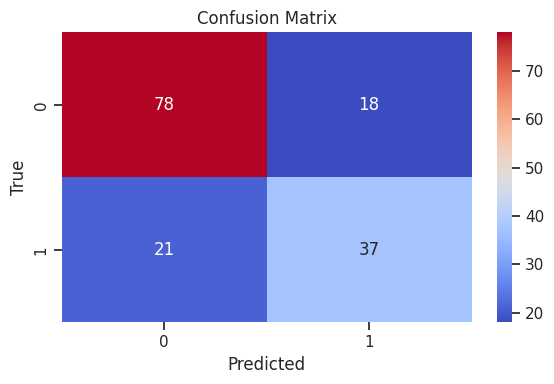

In [189]:
traintest(data)

### Show statistics on transformed data

In [177]:
def show_cm(cm):
  plt.figure(figsize=(6,4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.tight_layout()
  plt.show()

Accuracy: 78.57%

Classification report:


precision  recall  f1-score  support
0                  0.86    0.82      0.84   104.00
1                  0.65    0.72      0.69    50.00
accuracy           0.79    0.79      0.79     0.79
macro avg          0.76    0.77      0.76   154.00
weighted avg       0.79    0.79      0.79   154.00

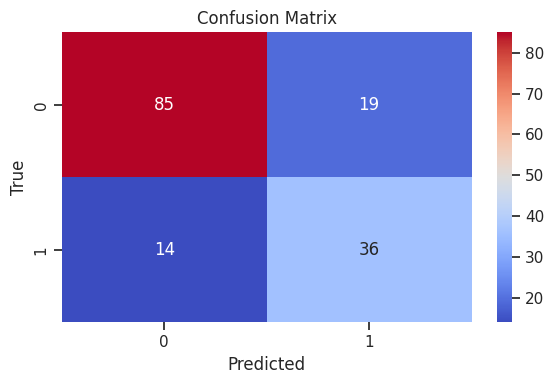

In [190]:
traintest(df)

# Balancing the target parameter

### Check how many values we have in our target

In [112]:
def get_distribution(df, column = 'result'):
  plt.figure(figsize=(4,3))
  sns.countplot(data = df, x=column, palette = 'pastel')
  plt.xlabel('Classes')
  plt.ylabel('Frequency')
  plt.title('Class distribution in target')
  plt.tight_layout()
  plt.show()

In [113]:
df['result'].describe()

count    768.000
mean       0.349
std        0.477
min        0.000
25%        0.000
50%        0.000
75%        1.000
max        1.000
Name: result, dtype: float64

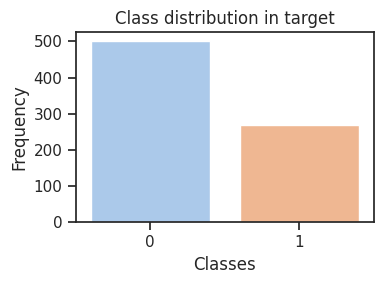

In [114]:
get_distribution(df)

## imblearn

### Create funcs to compare the number of samples

In [117]:
def count_vals(series, name = 'Before sampling'):
  count = Counter(series)
  result = pd.DataFrame([[count[0], count[1], count[0]+count[1], count[0]-count[1]]], columns=['Class 0', 'Class 1', 'Total', 'Difference'], index = [name])
  return result

In [196]:
def compare_balance(df, funcs, names):
  nos = count_vals(df['result'])
  for n in range(len(funcs)):
    df_X, df_y = funcs[n](df)
    sampled = count_vals(df_y, names[n])
    nos = pd.concat([nos, sampled])
  display(nos)

### Undersampling

Remove some samples from the majority class to make the distribution balanced.

In [116]:
def undersample(df):
  X, y = get_xy(df)
  nearmiss = NearMiss()
  X_res, y_res = nearmiss.fit_resample(X, y)
  return X_res, y_res

In [206]:
def us_df(df):
  us_X, us_y = undersample(df)
  us_X['result'] = us_y
  return us_X

In [217]:
undersampled = us_df(df)

In [219]:
compare_balance(df, [undersample], ['Undersampling'])

Class 0  Class 1  Total  Difference
Before sampling      500      268    768         232
Undersampling        268      268    536           0

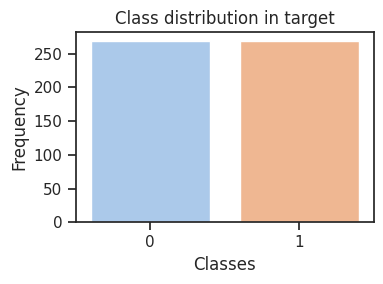

In [218]:
get_distribution(undersampled)

#### Evaluate the model performance on undersampling results

NearMiss undersampling

Accuracy: 64.81%

Classification report:


precision  recall  f1-score  support
0                  0.61    0.71      0.65    51.00
1                  0.69    0.60      0.64    57.00
accuracy           0.65    0.65      0.65     0.65
macro avg          0.65    0.65      0.65   108.00
weighted avg       0.65    0.65      0.65   108.00

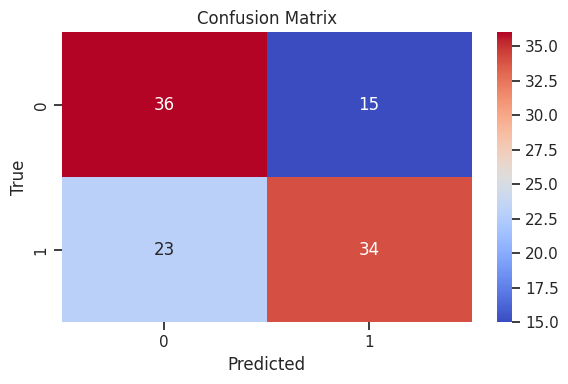

In [213]:
traintest(undersampled)

### Oversampling

In [208]:
def oversample(df):
  X,y = get_xy(df)
  ros = RandomOverSampler()
  X_res, y_res = ros.fit_resample(X,y)
  return X_res, y_res

def os_df(df):
  X, y = oversample(df)
  X['result'] = y
  return X

In [214]:
oversampled = os_df(df)

In [215]:
compare_balance(df, [undersample, oversample], ['Undersampling', 'Oversampling'])

Class 0  Class 1  Total  Difference
Before sampling      500      268    768         232
Undersampling        268      268    536           0
Oversampling         500      500   1000           0

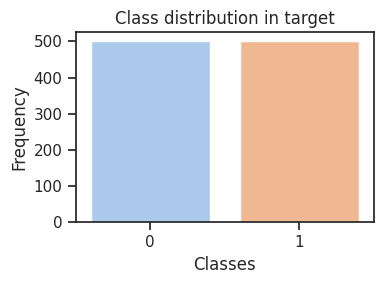

In [216]:
get_distribution(oversampled)

 #### Evaluate the model performance on undersampling results

Accuracy: 75.0%

Classification report:


precision  recall  f1-score  support
0                  0.70    0.78      0.73    89.00
1                  0.80    0.73      0.76   111.00
accuracy           0.75    0.75      0.75     0.75
macro avg          0.75    0.75      0.75   200.00
weighted avg       0.76    0.75      0.75   200.00

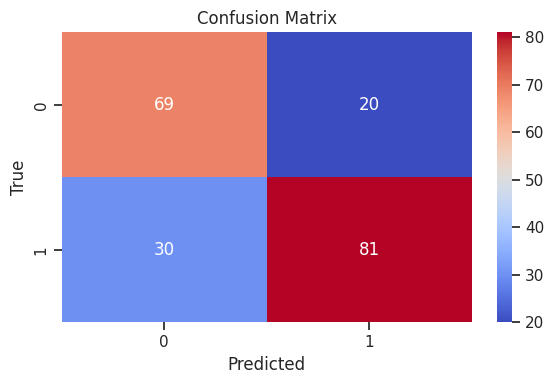

In [220]:
traintest(oversampled)

We still fall behind the transfromed df with no change to sampling but the result is betther than undersampling.

### SMOTETomek

### SMOTEENN